# 使用手寫辨識資料集, 觀察 PCA 算法

以 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化
,因為非監督模型的效果, 較難以簡單的範例看出來
,所以非監督偶數日提供的範例與作業, 主要目的在於觀察非監督模型的效果,
同學只要能感受到模型效果即可, 不用執著於搞懂程式的每一個部分

In [1]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [5]:
# 定義 PCA 與隨後的邏輯斯迴歸函數
logistic = SGDClassifier(loss='log', penalty='l2', max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [3]:
# 先執行 GridSearchCV 跑出最佳參數
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.915):
{'logistic__alpha': 0.01, 'pca__n_components': 30}


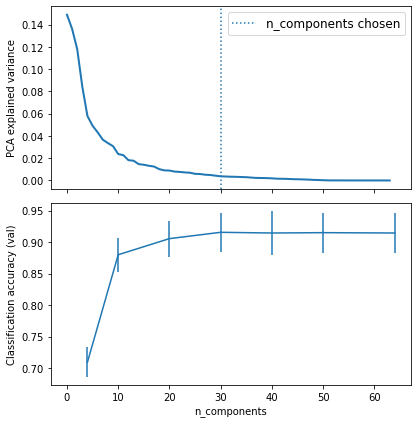

In [6]:
# 繪製不同 components 的 PCA 解釋度
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# 繪製不同採樣點的分類正確率
results = pd.DataFrame(search.cv_results_)

components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout()
plt.show()

# 觀察結果

explained variance ratio : 解釋變異性隨著 components 穩定下降

分類預測準確率 : 似乎也隨著 components 提升, 但是在 20 以後提升不多